In [2]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse as sp
import time
import pickle
import random
import torch
import torch.nn.functional as F
from torch_geometric.utils import remove_self_loops, add_self_loops
from sklearn import metrics
from model_all import Net
from sklearn import linear_model
import torch.backends.cudnn as cudnn
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler, SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
from load_data import load_data
from tqdm import tqdm
from statistics import mean


seed = 10
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)  # Numpy module.
random.seed(seed)  # Python random module.
torch.manual_seed(seed)
cudnn.benchmark = False
cudnn.deterministic = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Load data
pos = pd.read_csv('data/luad/pos.txt', header=None)
neg = pd.read_csv('data/luad/neg.txt', header=None)
index = pd.concat([pos,neg]).reset_index(drop=True).to_numpy().reshape(-1)   # index gene co nhan trong file gene_names.txt
label = np.zeros(2366)
label[0:179] = 1

# Chia tập dữ liệu 80% train và 20% test

In [4]:
index_train, index_test, label_train, label_test = train_test_split(index, label, test_size=0.2, shuffle=True, random_state=10)

# Tối ưu siêu tham số bằng Cross-Validation. Chia tập train thành 5 Fold

In [5]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Tối ưu hóa số ngưỡng quyết định liên kết Similarity Gene-Gene 
Chọn ngưỡng quyết định liên kết giữa 2 gene trong similarity gene-gene graph là [0.7,0.8,0.9]  
Cố định mô hình với các siêu tham số mặc định:  
Epoch = 1000, w1 = 0.1, w2 = 0.01, lr = 0.001, weight decay = 0, mô hình phân loại Logistic Regression  
== > Chọn ngưỡng = 0.7

In [ ]:
seed = 10
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)  # Numpy module.
random.seed(seed)  # Python random module.
torch.manual_seed(seed)
cudnn.benchmark = False
cudnn.deterministic = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


path = "./data/luad/"
EPOCH = 1000
w1 = 0.1
w2 = 0.01
learning_rate = 0.001
weight_decay = 0     

threshold = [ 0.7, 0.8, 0.9]

for t in threshold:
    print('Similarity Threshold = ', t)
    AUC = []
    AUPRC = []

    network1, network2, l_feature, r_feature, pos_edge, pos_edge1, Y = load_data(path, threshold_sim = t)
    for tr, val in kf.split(index_train,label_train):
        model = Net(l_feature, r_feature, network1, network2, 1, 19, 256, 128, pos_edge, pos_edge1).to(device)     # hop=1
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        model.train()
        for epoch in tqdm(range(1, EPOCH + 1)):

            pred, pred1, r_loss, _ = model()
            loss = F.binary_cross_entropy_with_logits(pred[index_train[tr]], Y[index_train[tr]])
            loss1 = F.binary_cross_entropy_with_logits(pred1[index_train[tr]], Y[index_train[tr]])
            loss = loss + w1 * loss1 + w2 * r_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            model.eval()
            _, _, _, x = model()

            # logistic regression model
            train_x = (x[index_train[tr]]).cpu().detach().numpy()
            train_y = Y[index_train[tr]].cpu().numpy()

            val_x = x[index_train[val]].cpu().detach().numpy()
            val_y = Y[index_train[val]].cpu().numpy().reshape(-1)

            regr = linear_model.LogisticRegression(max_iter=10000)
            regr.fit(train_x, train_y.ravel())
            pre = regr.predict_proba(val_x)
            pre = pre[:,1]
            y_pred = regr.predict(val_x)

            auprc = metrics.average_precision_score(val_y, pre)
            auc = metrics.roc_auc_score(val_y, pre)   

            AUC.append(auc)
            AUPRC.append(auprc)
            print(auc)
            print(auprc)
        

    np.savetxt(f"result/threshold/AUC_test_{t}.txt", AUC, delimiter="\t")
    np.savetxt(f"result/threshold/AUPRC_test_{t}.txt", AUPRC, delimiter="\t")
    

# Tối ưu hóa số lương EPOCH
Chạy EPOCH = 4000   
Cố định siêu tham số đã xác định: threshold = 0.7    
Các siêu tham số khác đặt mặc định, w1 = 0.1, w2 = 0.01, lr = 0.001, weight decay = 0   
Mô hình phân loại Logistic Regression   
== > Chọn EPOCH = 1000 


In [ ]:
seed = 10
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)  # Numpy module.
random.seed(seed)  # Python random module.
torch.manual_seed(seed)
cudnn.benchmark = False
cudnn.deterministic = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

path = "./data/luad/"
EPOCH = 4000
w1 = 0.1
w2 = 0.01
learning_rate = 0.001
weight_decay = 0     

threshold = 0.7

LOSS = []

network1, network2, l_feature, r_feature, pos_edge, pos_edge1, Y = load_data(path, threshold_sim = threshold)
for tr, val in kf.split(index_train,label_train):
    LOSS = []
    
    model = Net(l_feature, r_feature, network1, network2, 1, 19, 256, 128, pos_edge, pos_edge1).to(device)     # hop=1
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    model.train()
    for epoch in tqdm(range(1, EPOCH + 1)):

        pred, pred1, r_loss, _ = model()
        loss = F.binary_cross_entropy_with_logits(pred[index_train[tr]], Y[index_train[tr]])
        loss1 = F.binary_cross_entropy_with_logits(pred1[index_train[tr]], Y[index_train[tr]])
        loss = loss + w1 * loss1 + w2 * r_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        val_loss = F.binary_cross_entropy_with_logits(pred[index_train[val]], Y[index_train[val]])
        val_loss1 = F.binary_cross_entropy_with_logits(pred1[index_train[val]], Y[index_train[val]])
        val_loss = val_loss + w1 * val_loss1 + w2 * r_loss
        LOSS.append(val_loss.item())

    # Lưu lại LOSS  
    with open('result/epoch/embedding_loss.txt', 'w') as file:
        for item in LOSS:
            file.write(f"{item}\n")
    
    

# Tối ưu hóa learning rate
Cố định EPOCH = 1000, threshold = 0.7.  
learning_rate = [0.0005, 0.001, 0.002]  
tham số w1 = 0.1, w2 = 0.001  
== > Learning Rate = 0.001

In [ ]:
seed = 10
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)  # Numpy module.
random.seed(seed)  # Python random module.
torch.manual_seed(seed)
cudnn.benchmark = False
cudnn.deterministic = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


path = "./data/luad/"
EPOCH = 1000
w1 = 0.1
w2 = 0.01
learning_rate = [0.0005, 0.001, 0.002]
weight_decay = 0     

threshold = 0.7


for l in learning_rate:
    AUC = []
    AUPRC = []
    network1, network2, l_feature, r_feature, pos_edge, pos_edge1, Y = load_data(path, threshold_sim = threshold)
    
    for tr, val in kf.split(index_train,label_train):
        model = Net(l_feature, r_feature, network1, network2, 1, 19, 256, 128, pos_edge, pos_edge1).to(device)     # hop=1
        optimizer = torch.optim.Adam(model.parameters(), lr=l)
        model.train()
        for epoch in tqdm(range(1, EPOCH + 1)):

            pred, pred1, r_loss, _ = model()
            loss = F.binary_cross_entropy_with_logits(pred[index_train[tr]], Y[index_train[tr]])
            loss1 = F.binary_cross_entropy_with_logits(pred1[index_train[tr]], Y[index_train[tr]])
            loss = loss + w1 * loss1 + w2 * r_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            model.eval()
            _, _, _, x = model()

            # logistic regression model
            train_x = (x[index_train[tr]]).cpu().detach().numpy()
            train_y = Y[index_train[tr]].cpu().numpy()

            val_x = x[index_train[val]].cpu().detach().numpy()
            val_y = Y[index_train[val]].cpu().numpy().reshape(-1)

            regr = linear_model.LogisticRegression(max_iter=10000)
            regr.fit(train_x, train_y.ravel())
            pre = regr.predict_proba(val_x)
            pre = pre[:,1]
            y_pred = regr.predict(val_x)

            auprc = metrics.average_precision_score(val_y, pre)
            auc = metrics.roc_auc_score(val_y, pre)   

            AUC.append(auc)
            AUPRC.append(auprc)
        
    print(f'Voi learning_rate = {l}: mean(AUC) = {mean(AUC)}')
    print(f'Voi learning_rate = {l}: mean(AUPRC) = {mean(AUPRC)}')
    
    np.savetxt(f"result/learning_rate/AUC_test_{l}.txt", AUC, delimiter="\t")
    np.savetxt(f"result/learning_rate/AUPRC_test_{l}.txt", AUPRC, delimiter="\t")

# Tối ưu hóa w1
Cố định Epoch = 1000, t=0.7, w2 = 0.01, weight_decay = 0, learning_rate = 0.01. Tìm w1 = [0.05, 0.1, 0.2, 0.3]
===> chon w1 = 0.1

In [ ]:
seed = 10
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)  # Numpy module.
random.seed(seed)  # Python random module.
torch.manual_seed(seed)
cudnn.benchmark = False
cudnn.deterministic = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

path = "./data/luad/"
EPOCH = 1000
W1 = [0.005, 0.1, 0.2, 0.3]
w2 = 0.01
learning_rate = 0.001
weight_decay = 0     

threshold = 0.7


for w1 in W1:
    print('+ w1 = ', w1)
    AUC = []
    AUPRC = []
    network1, network2, l_feature, r_feature, pos_edge, pos_edge1, Y = load_data(path, threshold_sim = threshold)

    num_fold = -1
    for tr, val in kf.split(index_train,label_train):
        num_fold = num_fold + 1
        print(f"Xet Fold {num_fold}:")
        
        LOSS = []
        model = Net(l_feature, r_feature, network1, network2, 1, 19, 256, 128, pos_edge, pos_edge1).to(device)     # hop=1
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        model.train()
        for epoch in tqdm(range(1, EPOCH + 1)):

            pred, pred1, r_loss, _ = model()
            loss = F.binary_cross_entropy_with_logits(pred[index_train[tr]], Y[index_train[tr]])
            loss1 = F.binary_cross_entropy_with_logits(pred1[index_train[tr]], Y[index_train[tr]])
            loss = loss + w1 * loss1 + w2 * r_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            val_loss = F.binary_cross_entropy_with_logits(pred[index_train[val]], Y[index_train[val]])
            val_loss1 = F.binary_cross_entropy_with_logits(pred1[index_train[val]], Y[index_train[val]])
            val_loss = val_loss + w1 * val_loss1 + w2 * r_loss
            LOSS.append(val_loss.item())

        with torch.no_grad():
            model.eval()
            _, _, _, x = model()

            # logistic regression model
            train_x = (x[index_train[tr]]).cpu().detach().numpy()
            train_y = Y[index_train[tr]].cpu().numpy()

            val_x = x[index_train[val]].cpu().detach().numpy()
            val_y = Y[index_train[val]].cpu().numpy().reshape(-1)

            regr = linear_model.LogisticRegression(max_iter=10000)
            regr.fit(train_x, train_y.ravel())
            pre = regr.predict_proba(val_x)
            pre = pre[:,1]
            y_pred = regr.predict(val_x)

            auprc = metrics.average_precision_score(val_y, pre)
            auc = metrics.roc_auc_score(val_y, pre)   

            AUC.append(auc)
            AUPRC.append(auprc)
        np.savetxt(f"result/w1/embedding_loss_{w1}_fold{num_fold}.txt", LOSS, delimiter="\t")
        
    print(f'Voi w1 = {w1}: mean(AUC) = {mean(AUC)}')
    print(f'Voi w1 = {w1}: mean(AUPRC) = {mean(AUPRC)}')

    np.savetxt(f"result/w1/AUC_test_{w1}.txt", AUC, delimiter="\t")
    np.savetxt(f"result/w1/AUPRC_test_{w1}.txt", AUPRC, delimiter="\t")

# Tối ưu hóa w2
Cố định Epoch = 1000, t=0.7, w1 = 0.1, weight_decay = 0, learning_rate = 0.001. Tìm W2 = [0.005, 0.01, 0.015, 0.02, 0.025]
===> chon w1 = 0.015

In [ ]:
seed = 10
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)  # Numpy module.
random.seed(seed)  # Python random module.
torch.manual_seed(seed)
cudnn.benchmark = False
cudnn.deterministic = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

path = "./data/luad/"
EPOCH = 1000
w1 = 0.1
W2 = [0.005, 0.01, 0.015, 0.02, 0.025]
learning_rate = 0.001
weight_decay = 0     

threshold = 0.7


for w2 in W2:
    print('+ w2 = ', w2)
    AUC = []
    AUPRC = []
    network1, network2, l_feature, r_feature, pos_edge, pos_edge1, Y = load_data(path, threshold_sim = threshold)

    num_fold = -1
    for tr, val in kf.split(index_train,label_train):
        num_fold = num_fold + 1
        print(f"Xet Fold {num_fold}:")
        
        LOSS = []
        model = Net(l_feature, r_feature, network1, network2, 1, 19, 256, 128, pos_edge, pos_edge1).to(device)     # hop=1
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        model.train()
        for epoch in tqdm(range(1, EPOCH + 1)):

            pred, pred1, r_loss, _ = model()
            loss = F.binary_cross_entropy_with_logits(pred[index_train[tr]], Y[index_train[tr]])
            loss1 = F.binary_cross_entropy_with_logits(pred1[index_train[tr]], Y[index_train[tr]])
            loss = loss + w1 * loss1 + w2 * r_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            val_loss = F.binary_cross_entropy_with_logits(pred[index_train[val]], Y[index_train[val]])
            val_loss1 = F.binary_cross_entropy_with_logits(pred1[index_train[val]], Y[index_train[val]])
            val_loss = val_loss + w1 * val_loss1 + w2 * r_loss
            LOSS.append(val_loss.item())

        with torch.no_grad():
            model.eval()
            _, _, _, x = model()

            # logistic regression model
            train_x = (x[index_train[tr]]).cpu().detach().numpy()
            train_y = Y[index_train[tr]].cpu().numpy()

            val_x = x[index_train[val]].cpu().detach().numpy()
            val_y = Y[index_train[val]].cpu().numpy().reshape(-1)

            regr = linear_model.LogisticRegression(max_iter=10000)
            regr.fit(train_x, train_y.ravel())
            pre = regr.predict_proba(val_x)
            pre = pre[:,1]
            y_pred = regr.predict(val_x)

            auprc = metrics.average_precision_score(val_y, pre)
            auc = metrics.roc_auc_score(val_y, pre)   

            AUC.append(auc)
            AUPRC.append(auprc)
        np.savetxt(f"result/w2/embedding_loss_{w2}_fold{num_fold}.txt", LOSS, delimiter="\t")
        
    print(f'Voi w2 = {w2}: mean(AUC) = {mean(AUC)}')
    print(f'Voi w2 = {w2}: mean(AUPRC) = {mean(AUPRC)}')

    np.savetxt(f"result/w2/AUC_test_{w2}.txt", AUC, delimiter="\t")
    np.savetxt(f"result/w2/AUPRC_test_{w2}.txt", AUPRC, delimiter="\t")

# Tối ưu hóa Weight decay


In [ ]:
seed = 10
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)  # Numpy module.
random.seed(seed)  # Python random module.
torch.manual_seed(seed)
cudnn.benchmark = False
cudnn.deterministic = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

path = "./data/luad/"
EPOCH = 1000
w1 = 0.1
w2 = 0.015
learning_rate = 0.001
weight_decay = [0.01, 0.02, 0.03]     

threshold = 0.7


for wc in weight_decay:
    print('+ wc = ', wc)
    AUC = []
    AUPRC = []
    network1, network2, l_feature, r_feature, pos_edge, pos_edge1, Y = load_data(path, threshold_sim = threshold)

    num_fold = -1
    for tr, val in kf.split(index_train,label_train):
        num_fold = num_fold + 1
        print(f"Xet Fold {num_fold}:")
        
        LOSS = []
        model = Net(l_feature, r_feature, network1, network2, 1, 19, 256, 128, pos_edge, pos_edge1).to(device)     # hop=1
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=wc)
        model.train()
        for epoch in tqdm(range(1, EPOCH + 1)):

            pred, pred1, r_loss, _ = model()
            loss = F.binary_cross_entropy_with_logits(pred[index_train[tr]], Y[index_train[tr]])
            loss1 = F.binary_cross_entropy_with_logits(pred1[index_train[tr]], Y[index_train[tr]])
            loss = loss + w1 * loss1 + w2 * r_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            val_loss = F.binary_cross_entropy_with_logits(pred[index_train[val]], Y[index_train[val]])
            val_loss1 = F.binary_cross_entropy_with_logits(pred1[index_train[val]], Y[index_train[val]])
            val_loss = val_loss + w1 * val_loss1 + w2 * r_loss
            LOSS.append(val_loss.item())

        with torch.no_grad():
            model.eval()
            _, _, _, x = model()

            # logistic regression model
            train_x = (x[index_train[tr]]).cpu().detach().numpy()
            train_y = Y[index_train[tr]].cpu().numpy()

            val_x = x[index_train[val]].cpu().detach().numpy()
            val_y = Y[index_train[val]].cpu().numpy().reshape(-1)

            regr = linear_model.LogisticRegression(max_iter=10000)
            regr.fit(train_x, train_y.ravel())
            pre = regr.predict_proba(val_x)
            pre = pre[:,1]
            y_pred = regr.predict(val_x)

            auprc = metrics.average_precision_score(val_y, pre)
            auc = metrics.roc_auc_score(val_y, pre)   

            AUC.append(auc)
            AUPRC.append(auprc)
        np.savetxt(f"result/wc/embedding_loss_{wc}_fold{num_fold}.txt", LOSS, delimiter="\t")
        
    print(f'Voi wc = {wc}: mean(AUC) = {mean(AUC)}')
    print(f'Voi wc = {wc}: mean(AUPRC) = {mean(AUPRC)}')

    np.savetxt(f"result/wc/AUC_test_{wc}.txt", AUC, delimiter="\t")
    np.savetxt(f"result/wc/AUPRC_test_{wc}.txt", AUPRC, delimiter="\t")

# Tối ưu hóa alpha

In [ ]:
seed = 10
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)  # Numpy module.
random.seed(seed)  # Python random module.
torch.manual_seed(seed)
cudnn.benchmark = False
cudnn.deterministic = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

path = "./data/luad/"
EPOCH = 1000
w1 = 0.1
w2 = 0.015
learning_rate = 0.001
weight_decay = 0 
Alpha = [0.1, 0.15, 0.2, 0.25]
threshold = 0.7


for alpha in Alpha:
    print('+ alpha = ', alpha)
    AUC = []
    AUPRC = []
    network1, network2, l_feature, r_feature, pos_edge, pos_edge1, Y = load_data(path, threshold_sim = threshold)

    num_fold = -1
    for tr, val in kf.split(index_train,label_train):
        num_fold = num_fold + 1
        print(f"Xet Fold {num_fold}:")
        
        LOSS = []
        model = Net(l_feature, r_feature, network1, network2, 1, 19, 256, 128, pos_edge, pos_edge1, alpha=alpha).to(device)     # hop=1
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        model.train()
        for epoch in tqdm(range(1, EPOCH + 1)):

            pred, pred1, r_loss, _ = model()
            loss = F.binary_cross_entropy_with_logits(pred[index_train[tr]], Y[index_train[tr]])
            loss1 = F.binary_cross_entropy_with_logits(pred1[index_train[tr]], Y[index_train[tr]])
            loss = loss + w1 * loss1 + w2 * r_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            val_loss = F.binary_cross_entropy_with_logits(pred[index_train[val]], Y[index_train[val]])
            val_loss1 = F.binary_cross_entropy_with_logits(pred1[index_train[val]], Y[index_train[val]])
            val_loss = val_loss + w1 * val_loss1 + w2 * r_loss
            LOSS.append(val_loss.item())

        with torch.no_grad():
            model.eval()
            _, _, _, x = model()

            # logistic regression model
            train_x = (x[index_train[tr]]).cpu().detach().numpy()
            train_y = Y[index_train[tr]].cpu().numpy()

            val_x = x[index_train[val]].cpu().detach().numpy()
            val_y = Y[index_train[val]].cpu().numpy().reshape(-1)

            regr = linear_model.LogisticRegression(max_iter=10000)
            regr.fit(train_x, train_y.ravel())
            pre = regr.predict_proba(val_x)
            pre = pre[:,1]
            y_pred = regr.predict(val_x)

            auprc = metrics.average_precision_score(val_y, pre)
            auc = metrics.roc_auc_score(val_y, pre)   

            AUC.append(auc)
            AUPRC.append(auprc)
        np.savetxt(f"result/alpha/embedding_loss_{alpha}_fold{num_fold}.txt", LOSS, delimiter="\t")
        
    print(f'Voi alpha = {alpha}: mean(AUC) = {mean(AUC)}')
    print(f'Voi alpha = {alpha}: mean(AUPRC) = {mean(AUPRC)}')

    np.savetxt(f"result/alpha/AUC_test_{alpha}.txt", AUC, delimiter="\t")
    np.savetxt(f"result/alpha/AUPRC_test_{alpha}.txt", AUPRC, delimiter="\t")

# Huấn luyện và lưu tham số mô hình


In [ ]:
seed = 10
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)  # numpy module.
random.seed(seed)  # python random module.
torch.manual_seed(seed)
cudnn.benchmark = False
cudnn.deterministic = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

path = "./data/luad/"
EPOCH = 1000
w1 = 0.1
w2 = 0.015
alpha = 0.1
learning_rate = 0.001
weight_decay = 0 
threshold = 0.7

network1, network2, l_feature, r_feature, pos_edge, pos_edge1, Y = load_data(path, threshold_sim = threshold)

model = Net(l_feature, r_feature, network1, network2, 1, 19, 256, 128, pos_edge, pos_edge1, alpha=alpha).to(device)     # hop=1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
model.train()

for epoch in tqdm(range(1, EPOCH + 1)):

    pred, pred1, r_loss, _ = model()
    loss = F.binary_cross_entropy_with_logits(pred[index_train], Y[index_train])
    loss1 = F.binary_cross_entropy_with_logits(pred1[index_train], Y[index_train])
    loss = loss + w1 * loss1 + w2 * r_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

torch.save(model.state_dict(), 'result/model/model.pth')

with torch.no_grad():
    model.eval()
    _, _, _, x = model()
    x1 = x.cpu().detach().numpy()
    np.savetxt("result/model/gene.txt", x1, delimiter=",")


# Chọn phương pháp cân bằng nhãn
Do kết quả thu được chênh lệch ko đáng kể. Sử dụng thêm SMOTE sẽ làm phức tạp thêm mô hình. Vậy lên em chỉ sủ dụng RandomOverSampling.

In [154]:
def sample_balancing(x_train, y_train, num_ovesampling = None):
    # n_random: so luong mau sau khi RandomOverSampling
    if num_ovesampling != None:
        random_over_sampler = RandomOverSampler(sampling_strategy={1: num_ovesampling}, random_state=10)
        x_resampled_1, y_resampled_1 = random_over_sampler.fit_resample(x_train, y_train)

        smote = SMOTE()
        x_resampled_2, y_resampled_2 = smote.fit_resample(x_resampled_1, y_resampled_1)
    else: 
        random_over_sampler = RandomOverSampler(random_state=10)
        x_resampled_2, y_resampled_2 = random_over_sampler.fit_resample(x_train, y_train)

    return x_resampled_2, y_resampled_2

In [8]:
x = pd.read_csv('result/model/gene.txt', header=None, sep=',')
y = label

print('Train Set: ')
x_train = x.iloc[index_train, :]
x_train = x_train.to_numpy()
y_train = label_train
print('+ size: ', len(x_train))

print('Test Set: ')
x_test = x.iloc[index_test, :]
x_test = x_test.to_numpy()
y_test = label_test
print('+ size: ', len(x_test))



Train Set: 
+ size:  1892
Test Set: 
+ size:  474


In [156]:
from sklearn.linear_model import LogisticRegression

MAX_ITER = 10000
fixed_solver = 'lbfgs'
fixed_C = 2
fixed_penalty = 'l2'
kf = KFold(n_splits=5, shuffle=True, random_state=42)

num_oversampling = [1000, 1200, 1500, None]
for n in num_oversampling:
    print('Số lượng mẫu lấy bằng RandomOverSampling: ', n)
    lg = LogisticRegression(solver=fixed_solver, penalty=fixed_penalty, C=fixed_C, max_iter=MAX_ITER, random_state=42)

    AUC = []
    AUPRC = []

    for train_index, val_index in kf.split(x_train, y_train):

        re_x, re_y = sample_balancing(x_train[train_index], y_train[train_index], num_ovesampling=n)

        lg.fit(re_x, re_y)
        y_pred = lg.predict(x_train[val_index])
        pred = lg.predict_proba(x_train[val_index])[:, 1]

        AUC.append(metrics.roc_auc_score(y_train[val_index], pred))
        AUPRC.append(metrics.average_precision_score(y_train[val_index], pred))


    np.savetxt(f"result/resampling/AUC_test_{n}.txt", AUC, delimiter="\t")
    np.savetxt(f"result/resampling/AUPRC_test_{n}.txt", AUPRC, delimiter="\t")

    print('+ AUC: ', mean(AUC))
    print('+ AUPRC: ', mean(AUPRC))

Số lượng mẫu lấy bằng RandomOverSampling:  1000
+ AUC:  0.977755999909061
+ AUPRC:  0.8836281480620364
Số lượng mẫu lấy bằng RandomOverSampling:  1200
+ AUC:  0.9777975601073241
+ AUPRC:  0.8849974317137701
Số lượng mẫu lấy bằng RandomOverSampling:  1500
+ AUC:  0.9779418194582572
+ AUPRC:  0.8848967821051148
Số lượng mẫu lấy bằng RandomOverSampling:  None
+ AUC:  0.9780557312404563
+ AUPRC:  0.8859680465730053


# Tối ưu hóa mô hình LR

Mô hình Logistic Regression có 3 siêu tham số cần chọn đó là phương pháp hiệu chỉnh, hệ số hiệu chỉnh và thuật toán tối ưu. Với mỗi thuật toán tối ưu sẽ hỗ trợ một số phương pháp hiệu chỉnh khác nhau. Trong đó:

### Thuật toán tối ưu:

- **Newton's method** (`'l2'`, `'none'`): Thuật toán này cũng hướng tới việc xấp xỉ hàm loss bậc 2 tương tự như Gradient Descent, nhưng khác ở chỗ nó sử dụng phép xấp xỉ bậc 2, tại mỗi bước nó sẽ xấp xỉ hàm số f(x) bằng 1 hàm số bậc 2 quanh x và tiến 1 bước về cực đại hoặc cực tiểu của hàm đó.
- **Limited-memory Broyden–Fletcher–Goldfarb–Shanno Algorithm** (`'l2'`, `'none'`): Tương tự như Newton's method nhưng ma trận Hessian được tính gần đúng bằng cách đánh giá đạo hàm. Phương pháp này rất tốt cho tập dữ liệu nhỏ.
- **A Library for Large Linear Classification** (`'l1'`, `'l2'`): Là một phương pháp linear classification mà hỗ trợ Logistic Regression và linear SVM.
- **Stochastic Average Gradient** (`'l2'`, `'none'`): Phương pháp SAG thực hiện tối ưu hóa tổng của một số hữu hạn các hàm lỗi trơn.
- **SAGA** (`'elasticnet'`, `'l2'`, `'l1'`, `'none'`): Là một biến thể của SAG nhưng hỗ trợ L1, nó hoạt động rất tốt với những bộ dữ liệu rất lớn.

### Phương pháp hiệu chỉnh

- **none**: Không hiệu chỉnh
- **l1**: Hiệu chỉnh L1
- **l2**: Hiệu chỉnh L2
- **elasticnet**: Kết hợp giữa L1 và L2

### Nghịch đảo của hệ số hiệu chỉnh (C) - C càng nhỏ, hiệu chỉnh càng mạnh:

\begin{equation}
C \in \{1, 2, 5, 10, 16\} 
\end{equation}

## Tối ưu hóa thuật toán tối ưu
cố định phương pháp hiệu chình là l2 và C = 2, thay đổi thuật toán tối ưu  
===> Chọn newton-cg

In [157]:
from sklearn.linear_model import LogisticRegression

MAX_ITER = 10000
solvers = {'newton-cg':['l2', 'none'], 'lbfgs':['l2', 'none'], 'liblinear':['l1', 'l2'], 'sag':['l2', 'none'], 'saga':['elasticnet', 'l1', 'l2', 'none']}
fixed_C = 2
fixed_penalty = 'l2'
num_oversampling = None

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for s in solvers.keys():
    print('Thuật toán tối ưu: ', s)
    lg = LogisticRegression(solver=s, penalty=fixed_penalty, C=fixed_C, max_iter=MAX_ITER, random_state=42)

    AUC = []
    AUPRC = []

    for train_index, val_index in kf.split(x_train, y_train):

        re_x, re_y = sample_balancing(x_train[train_index], y_train[train_index], num_ovesampling=n)

        lg.fit(re_x, re_y)
        y_pred = lg.predict(x_train[val_index])
        pred = lg.predict_proba(x_train[val_index])[:, 1]

        AUC.append(metrics.roc_auc_score(y_train[val_index], pred))
        AUPRC.append(metrics.average_precision_score(y_train[val_index], pred))


    np.savetxt(f"result/solver/AUC_test_{s}.txt", AUC, delimiter="\t")
    np.savetxt(f"result/solver/AUPRC_test_{s}.txt", AUPRC, delimiter="\t")

    print('+ AUC: ', mean(AUC))
    print('+ AUPRC: ', mean(AUPRC))

Thuật toán tối ưu:  newton-cg
+ AUC:  0.9780557312404563
+ AUPRC:  0.8859680465730053
Thuật toán tối ưu:  lbfgs
+ AUC:  0.9780557312404563
+ AUPRC:  0.8859680465730053
Thuật toán tối ưu:  liblinear
+ AUC:  0.9780718821924932
+ AUPRC:  0.8859137996142314
Thuật toán tối ưu:  sag


+ AUC:  0.978038215037969
+ AUPRC:  0.885818827105604
Thuật toán tối ưu:  saga
+ AUC:  0.9780557312404563
+ AUPRC:  0.8857948336237252


## Tối ưu hệ số hiệu chỉnh
===> C = 2

In [158]:
from sklearn.linear_model import LogisticRegression

MAX_ITER = 10000
solvers = 'newton-cg' 
C = [1,2,5,10,16]
fixed_penalty = 'l2'
num_oversampling = None

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for c in C:
    print('Hệ số hiệu chỉnh: ', c)
    lg = LogisticRegression(solver=solvers, penalty=fixed_penalty, C=c, max_iter=MAX_ITER, random_state=42)

    AUC = []
    AUPRC = []

    for train_index, val_index in kf.split(x_train, y_train):

        re_x, re_y = sample_balancing(x_train[train_index], y_train[train_index], num_ovesampling=n)

        lg.fit(re_x, re_y)
        y_pred = lg.predict(x_train[val_index])
        pred = lg.predict_proba(x_train[val_index])[:, 1]

        AUC.append(metrics.roc_auc_score(y_train[val_index], pred))
        AUPRC.append(metrics.average_precision_score(y_train[val_index], pred))


    np.savetxt(f"result/c/AUC_test_{c}.txt", AUC, delimiter="\t")
    np.savetxt(f"result/c/AUPRC_test_{c}.txt", AUPRC, delimiter="\t")

    print('+ AUC: ', mean(AUC))
    print('+ AUPRC: ', mean(AUPRC))

Hệ số hiệu chỉnh:  1
+ AUC:  0.9776141300320365
+ AUPRC:  0.8848543644551904
Hệ số hiệu chỉnh:  2
+ AUC:  0.9780557312404563
+ AUPRC:  0.8859680465730053
Hệ số hiệu chỉnh:  5
+ AUC:  0.9784593156109433
+ AUPRC:  0.8853231869965567
Hệ số hiệu chỉnh:  10
+ AUC:  0.9785671972349193
+ AUPRC:  0.8857843934150282
Hệ số hiệu chỉnh:  16
+ AUC:  0.978451185047874
+ AUPRC:  0.8850067008405111


In [198]:
# thử sử dụng LR trên tập Test

from sklearn.linear_model import LogisticRegression

MAX_ITER = 100000
solvers = 'newton-cg' 
C = 2
fixed_penalty = 'l2'
num_oversampling = None


lg = LogisticRegression(solver=solvers, penalty=fixed_penalty, C= 2, max_iter=MAX_ITER, random_state=42)

AUC = []
AUPRC = []
F1 = []


re_x, re_y = sample_balancing(x_train, y_train, num_ovesampling=num_oversampling)

lg.fit(re_x, re_y)
y_pred = lg.predict(x_test)
pred = lg.predict_proba(x_test)[:, 1]

AUC.append(metrics.roc_auc_score(y_test, pred))
AUPRC.append(metrics.average_precision_score(y_test, pred))
F1.append(metrics.f1_score(y_test, y_pred))




print('+ AUC: ', mean(AUC))
print('+ AUPRC: ', mean(AUPRC))
print('+ F1 ', mean(F1))

+ AUC:  0.9001585623678646
+ AUPRC:  0.7081993762226922
+ F1  0.5811965811965812


# Tối ưu hóa RandomForest
Random forest có 2 siêu tham số cần lựa chọn là số cây trong rừng và độ đo chất lượng của phép tách.

Với số cây, nhóm sẽ xét những số cây như sau:

\begin{equation}
\text{trees} \in \{10, 20, 50, 100, 150, 200, 300\}

\end{equation}

Với các độ đo, nhóm sẽ xét 2 độ đo là:

- **entropy: Information Gain** - Được tính theo độ giảm của entropy ban đầu của hệ thống. Entropy càng lớn thì hệ thống càng hỗn loạn, phép tách làm giảm nhiều entropy đồng nghĩa với việc làm giảm nhiều độ hỗn loạn của thông tin trong hệ thống.
- **gini: Gini Impurity** - Thể hiện mức độ sai khi ta chọn ngẫu nhiên 1 phần tử từ tập dữ liệu. Độ đo này đơn giản hơn nhiều so với Information Gain.

## Tối ưu hóa số lương cây

In [160]:
# Cố định độ đo là entropy, thay đổi số cây
from sklearn.ensemble import RandomForestClassifier

trees = [10, 20, 50, 100, 150, 200, 300]
MAX_ITER = 10000
num_oversampling = None

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for t in trees:
    F1 = []
    print('Số lượng cây: ', t)
    rf = RandomForestClassifier(n_estimators=t, criterion='entropy', random_state=42)

    AUC = []
    AUPRC = []

    for train_index, val_index in kf.split(x_train, y_train):
        re_x, re_y = sample_balancing(x_train[train_index], y_train[train_index], num_ovesampling=n)
        rf.fit(re_x, re_y)

        y_pred = rf.predict(x_train[val_index])
        F1.append(metrics.f1_score(y_train[val_index], y_pred))

    np.savetxt(f"result/randomforest/tree/F1_{t}.txt", AUPRC, delimiter="\t")

    print('+ F1: ', mean(F1))


Số lượng cây:  10
+ F1:  0.7887332422947595
Số lượng cây:  20
+ F1:  0.7880192754802132
Số lượng cây:  50
+ F1:  0.7891466935777759
Số lượng cây:  100
+ F1:  0.8034529272701989
Số lượng cây:  150
+ F1:  0.8040509366017731
Số lượng cây:  200
+ F1:  0.79660465787007
Số lượng cây:  300
+ F1:  0.8004430417084537


## Tối ưu hóa độ đo  
===> chọn entropy

In [164]:
from sklearn.ensemble import RandomForestClassifier

trees = 150 
MAX_ITER = 10000
num_oversampling = None
criterion = ['entropy', 'gini']

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for cri in criterion:
    F1 = []
    print('Độ đo: ', cri)
    rf = RandomForestClassifier(n_estimators=t, criterion=cri, random_state=42)

    AUC = []
    AUPRC = []

    for train_index, val_index in kf.split(x_train, y_train):
        re_x, re_y = sample_balancing(x_train[train_index], y_train[train_index], num_ovesampling=n)
        rf.fit(re_x, re_y)

        y_pred = rf.predict(x_train[val_index])
        F1.append(metrics.f1_score(y_train[val_index], y_pred))

    np.savetxt(f"result/randomforest/cri/F1_{cri}.txt", AUPRC, delimiter="\t")

    print('+ F1: ', mean(F1))

Độ đo:  entropy
+ F1:  0.8004430417084537
Độ đo:  gini
+ F1:  0.7993165222768496


# So sanh LR va RF

In [165]:
from sklearn.ensemble import RandomForestClassifier
MAX_ITER = 100000
num_oversampling = None

# sieu tham so mo hinh LR
solvers = 'newton-cg' 
C = 2
fixed_penalty = 'l2'

# sieu tham so mo hinh RandomForest
trees = 20 
criterion = 'entropy'

kf = KFold(n_splits=5, shuffle=True, random_state=42)

lg = LogisticRegression(solver=solvers, C=2, penalty=fixed_penalty, max_iter=MAX_ITER, random_state=42)
rf = RandomForestClassifier(n_estimators=trees, criterion=criterion, random_state=42)

F1_LR = []
F1_RF = []

for train_index, val_index in kf.split(x_train, y_train):
    re_x, re_y = sample_balancing(x_train[train_index], y_train[train_index], num_ovesampling=n)

    # training
    lg.fit(re_x, re_y)
    rf.fit(re_x, re_y)

    y_pred1 = lg.predict(x_train[val_index])
    y_pred2 = rf.predict(x_train[val_index])
    F1_LR.append(metrics.f1_score(y_train[val_index], y_pred1))
    F1_RF.append(metrics.f1_score(y_train[val_index], y_pred2))

np.savetxt(f"result/so_sanh/F1_LR.txt", F1_LR, delimiter="\t")
np.savetxt(f"result/so_sanh/F1_RF.txt", F1_RF, delimiter="\t")

print('Mean F1 LR: ', mean(F1_LR))
print('Mean F1 RF: ', mean(F1_RF))

Mean F1 LR:  0.6263725330918429
Mean F1 RF:  0.7880192754802132


# Train RF

In [9]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier

index_train, index_test, label_train, label_test = train_test_split(index, label, test_size=0.2, shuffle=True, random_state=10)


trees = 150
criterion = 'entropy'
rf = RandomForestClassifier(n_estimators=trees, criterion=criterion, random_state=10, min_samples_split=3)
num_oversampling = None

random_over_sampler = RandomOverSampler(random_state=10, sampling_strategy='auto')
re_x, re_y = random_over_sampler.fit_resample(x_train, y_train)
rf.fit(re_x, re_y)
y_pred = rf.predict(x_test)
print(metrics.f1_score(y_test, y_pred))
print(metrics.accuracy_score(y_test, y_pred))

0.6279069767441862
0.9324894514767933


474

<Figure size 1000x1000 with 0 Axes>

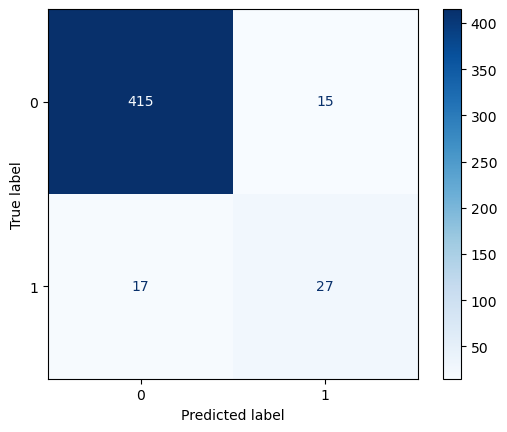

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
# plt.savefig('./images/conf_matrix.png', facecolor='whitesmoke')
len(y_test)


{0, 1}